# Dimensionality reduction for 3D-LLM



In [ ]:
#linear algebra
import numpy as np
#data structures
import pandas as pd
#ml models
import scipy as sp
import sklearn
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
import statsmodels.api as sm
#off the warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The `Olivetti Faces dataset` component analysis.

In [ ]:
import numpy as np
from PIL import Image
import os

def load_images_from_folder(folder):
    images = []
    targets = []
    image_names = []
    target = 0  # начальный номер класса

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert('L')  # в оттенки серого
                    img = img.resize((64, 64))  # приводим к размеру 64x64
                    img_array = np.array(img)
                    image_names.append(file)
                    images.append(img_array.reshape(-1))  # <- Ключевое изменение: преобразуем в (4096,)
                    targets.append(target)
                except Exception as e:
                    print(f"Ошибка при загрузке {img_path}: {e}")

        # Увеличиваем target при переходе в новую подпапку (если структура как в Olivetti)
        if dirs:
            target += 1

    if not images:
        raise ValueError(f"В папке {folder} не найдены изображения")

    return np.array(images), np.array(targets), np.array(image_names)

# Пример использования:
folder_path = "Model"
images, targets, image_names = load_images_from_folder(folder_path)

# Проверяем, что загружено правильно
print(f"Загружено {len(images)} изображений")
print(f"Размерность данных: {images.shape}")  # Должно быть (n_samples, height, width)

# Можно привести к формату Olivetti faces (n_samples, n_features)
X = images.reshape(len(images), -1)
print(f"Форма данных после reshape: {X.shape}")

Загружено 136 изображений
Размерность данных: (136, 4096)
Форма данных после reshape: (136, 4096)


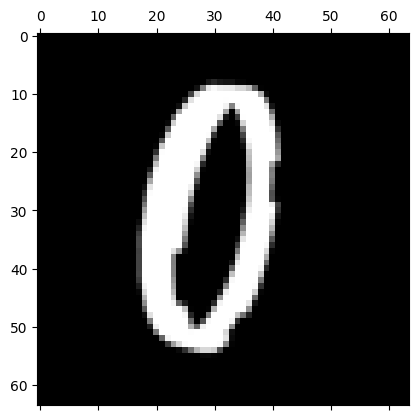

In [ ]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState


data = images
target = targets

#data
plt.matshow(data[0].reshape(64,64), cmap='gray');

In [ ]:
data

array([[  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
len(data)

136

In [ ]:
data.shape

(136, 4096)

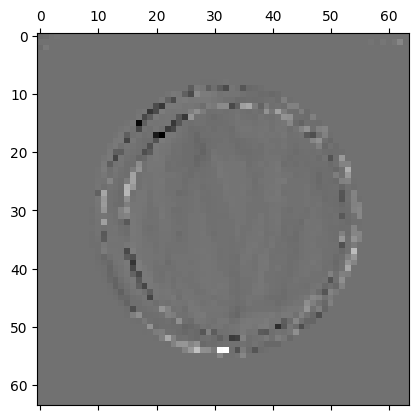

In [ ]:
U, sigma, V = np.linalg.svd(data)

plt.matshow(V[:,40].reshape(64,64), cmap='gray');

Questions:
* Who is that criminally looking guy?

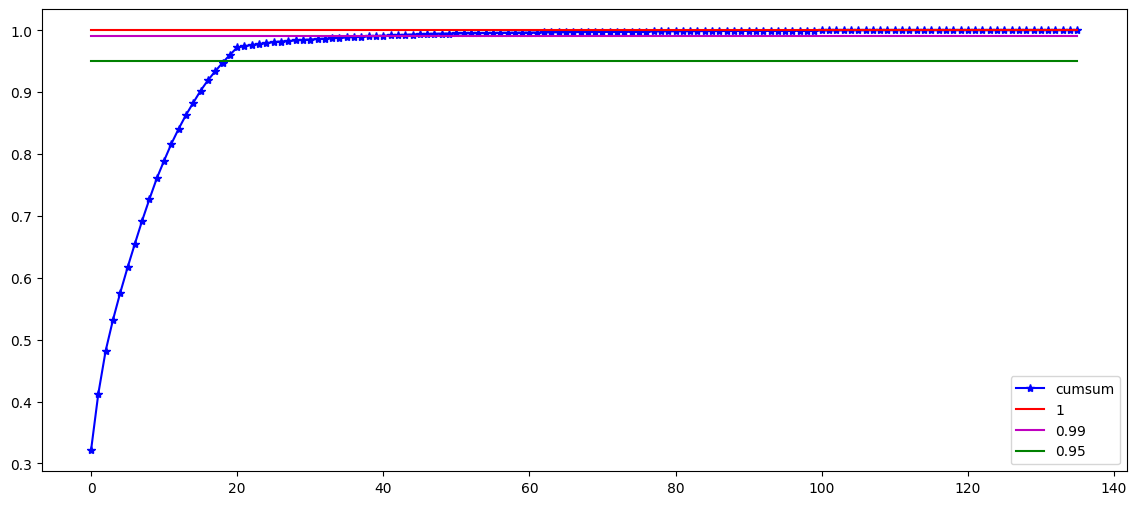

In [ ]:
sample_size, sample_dim = np.shape(data);

# how much variance were explained?
plt.figure(figsize = (14,6))
plt.plot(range(sample_size), np.cumsum(sigma) / np.sum(sigma), "-*b", label = 'cumsum')
plt.plot(range(sample_size), [1]*sample_size, "r")
plt.plot(range(sample_size), [0.99]*sample_size, "m")
plt.plot(range(sample_size), [0.95]*sample_size, "g")
plt.legend(['cumsum', '1', '0.99', '0.95']);

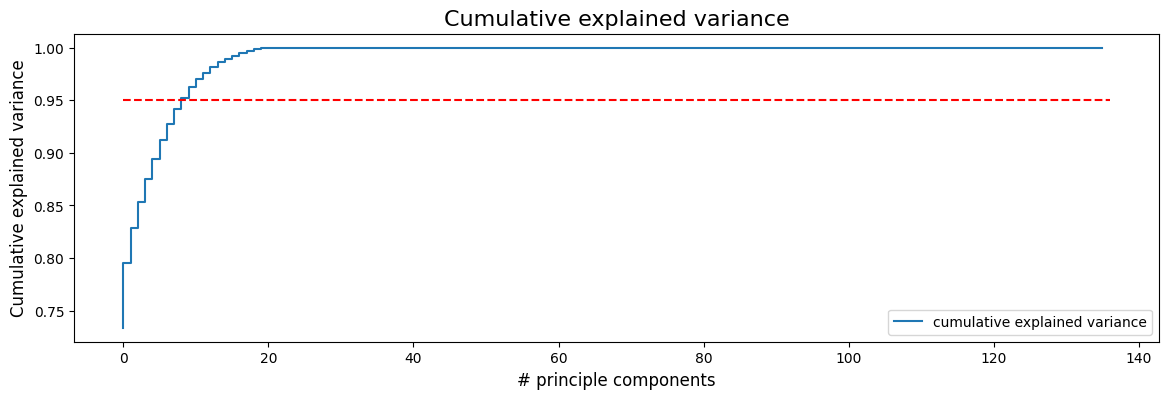

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(data)

plt.figure(figsize=(14, 4))

plt.step(range(136), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.legend(loc='lower right')
plt.hlines(y=0.95, xmin=0, xmax=len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.show()

In [ ]:
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.

    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)

    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.4, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')
            ax.add_artist(ab)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

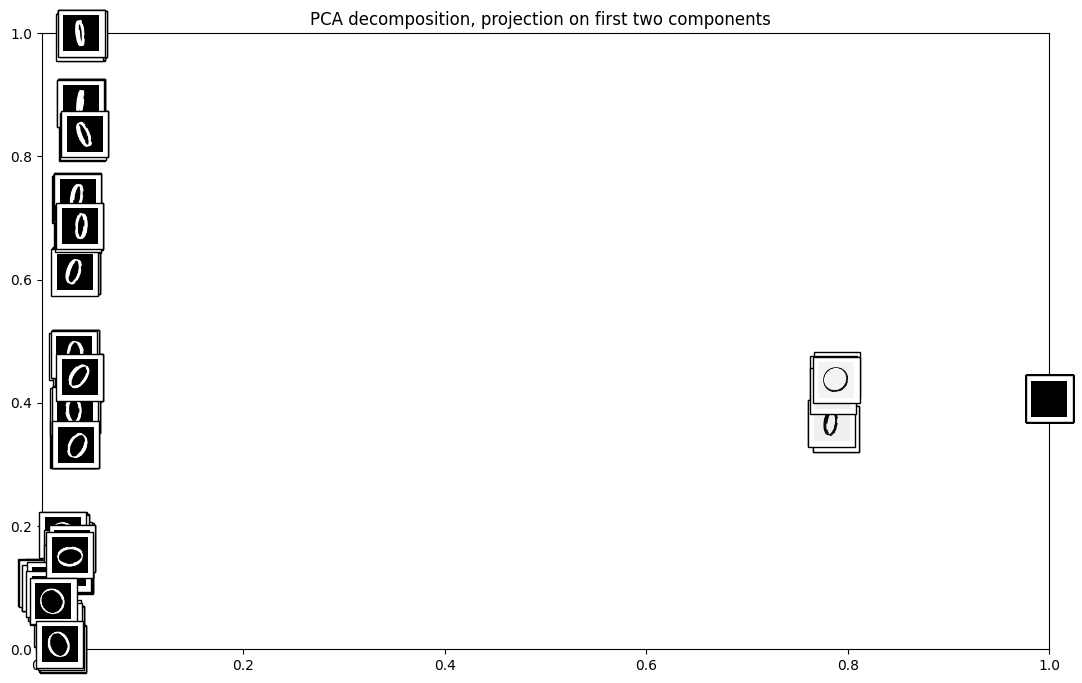

In [ ]:
X_projected = PCA(136).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "PCA decomposition, projection on first two components  ")

## 4. Estimation of intrinsic dimension

From the paper:


*There is a consensus in the high-dimensional data analysis community that the only reason any methods work in very high dimensions is that, in fact, the data are not truly high-dimensional. Rather, they are embedded in a high-dimensional space,
but can be efficiently summarized in a space of a much lower dimension, such as a nonlinear manifold.*

*Then one can reduce dimension without losing much information for many types of real-life high-dimensional data, such as images, and avoid many of the “curses of dimensionality”. Learning these data manifolds can improve
performance in classification and other applications, but if the data structure is
complex and nonlinear, dimensionality reduction can be a hard problem.*

#####  NIPS 2004: https://papers.nips.cc/paper/2577-maximum-likelihood-estimation-of-intrinsic-dimension.pdf

In [ ]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel

how to use
----------

The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.

This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.

Here is one example with swiss roll :

from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)

k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval,
                             X,
                             mode='bootstrap',
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1,
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).

"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstance betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors
            #232 111 133
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

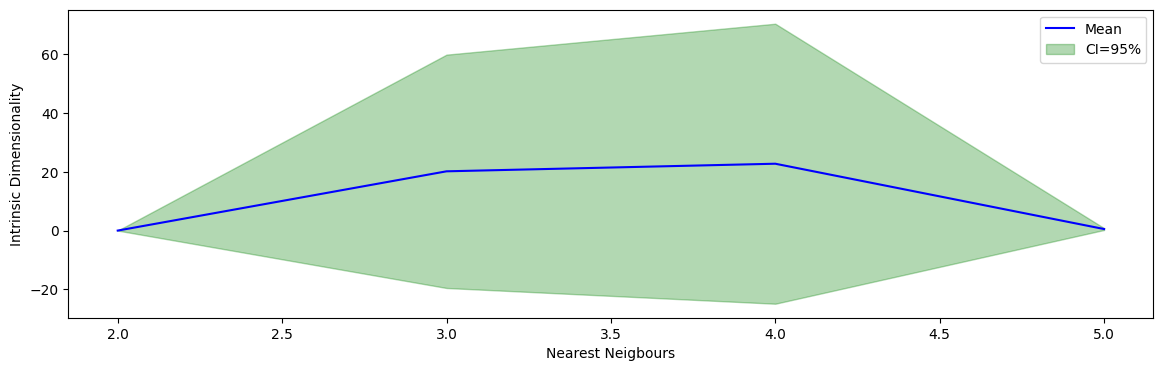

In [ ]:
import warnings
warnings.filterwarnings("ignore")

k1 = 1 # start of interval(included)
k2 = 5 # end of interval(included)
nb_iter = 3 # more iterations more accuracy
# intrinsic_dim_scale_interval gives better estimation
intdim_k_repeated = repeated(intrinsic_dim_scale_interval,
                             data,
                             mode='bootstrap',
                             nb_iter=nb_iter, # nb_iter for bootstrapping
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

x = np.arange(k1, k2+1)

plt.figure(figsize=(14, 4))
plt.plot(x, np.mean(intdim_k_repeated, axis=0), 'b', label='Mean') # it is the mean walue
plt.fill_between(x,
                 np.mean(intdim_k_repeated, axis=0) -
                 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) +
                 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='CI=95%',
                 color='g')
plt.xlabel("Nearest Neigbours")
plt.ylabel("Intrinsic Dimensionality")
plt.legend()
plt.show()

## 5. Manifold learning  

It is big part of research on the application of geometry and in particular differential geometry to machine learning.

We are going to touch a couple popular algorithms from: https://scikit-learn.org/stable/modules/manifold.html

The manifold learning methods also assumes nono-linear algorithms for dimensionality reduction.

Questions:
* Is `PCA` linear?
* Can we compose non-linear `PCA` from the linear?

Principal Component Analysis (PCA), Independent Component Analysis, Linear Discriminant Analysis, and others. These algorithms define specific rubrics to choose an good linear projection of the data.

These methods can be powerful, but often miss important non-linear structure in the data.


**Lets go with some other liner method : Independent Component Analysis `ICA`.**
FastICA algorithm: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

<img src="https://cf2.ppt-online.org/files2/slide/c/CarDgVY6t91bypGImvqBcR3OdAjWhFTZ2JQxL4ofM/slide-6.jpg" alt="Drawing" style="width: 700px;" />

In [ ]:
# let's leave 20 peaple from faces to get more comprehencible visualisation

data = images
target = targets


data = data[target <20]
target = target[target <20]

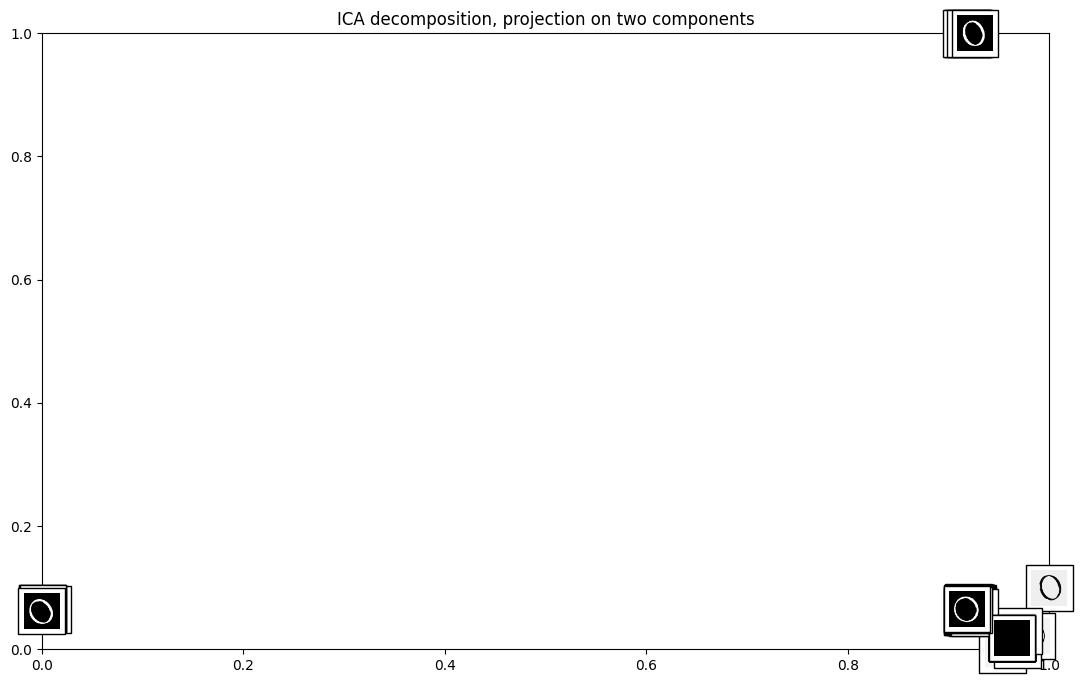

In [ ]:
from sklearn.decomposition import FastICA

X_projected = FastICA(20, random_state = 42).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "ICA decomposition, projection on two components")

Will the decomposition change with the `n_components` changed?

**The most popular nonlinear algorithms: tSNE,  MDS, Isomap**

t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

1. For each data point $x_i$ we’ll center a Gaussian distribution over that point. Then we measure the density of all points $x_j$ under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities $P_{ij}$ for all points in higher dimentional space.

2. Get the second set of probablities $Q_{ij}$ for Cauchy distribution (with is Students t-distribution with one degree of freedom), which allow for better modeling of far apart distances, becouse of heavier tails.

3. Map these two sets of probabilities ($ P_{ij}; Q_{ij}$)to each other, optimiing KL-divergence.

Where Kullback–Leibler divergence can be defined as

$$ D_{KL} (P || Q) = \sum P(x) log(\frac{P(x)}{Q(x)})$$

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 136 samples in 0.001s...
[t-SNE] Computed neighbors for 136 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 136 / 136
[t-SNE] Mean sigma: 3002.073492
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 41.7595177, gradient norm = 0.1503087 (50 iterations in 0.053s)
[t-SNE] Iteration 100: error = 41.5171165, gradient norm = 0.1483817 (50 iterations in 0.072s)
[t-SNE] Iteration 150: error = 41.4267960, gradient norm = 0.1488716 (50 iterations in 0.032s)
[t-SNE] Iteration 200: error = 41.3745499, gradient norm = 0.1478873 (50 iterations in 0.035s)
[t-SNE] Iteration 250: error = 41.3376083, gradient norm = 0.1485243 (50 iterations in 0.035s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.337608
[t-SNE] Iteration 300: error = -0.3091961, gradient norm = 0.0199538 (50 iterations in 0.032s)
[t-SNE] Iteration 350: error = -0.4445869, gradient norm = 0.0265

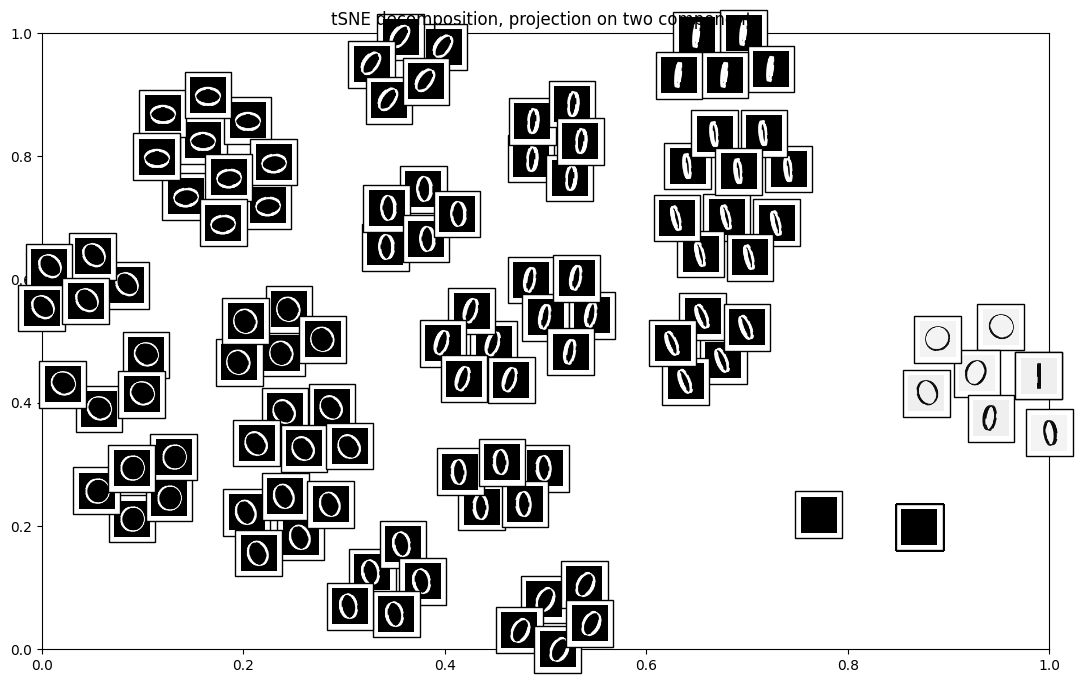

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, n_iter = 1000, metric='euclidean', learning_rate= 10, verbose=2, random_state = 42)

X_projected = tsne.fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "tSNE decomposition, projection on two components")

### Isometric Mapping (Isomap)

Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. Goes in three stages:

1. **Nearest neighbor search**.

2. **Shortest-path graph search.**

3. **Partial eigenvalue decomposition**. The embedding is encoded in the eigenvectors corresponding to the  largest eigenvalues of the  isomap kernel.

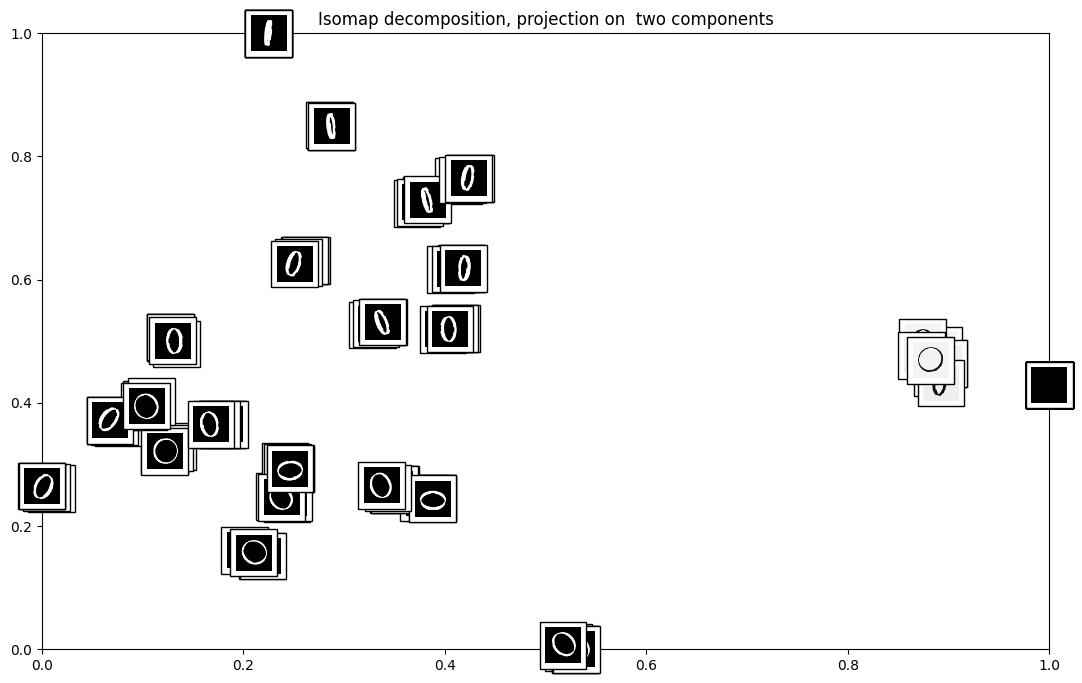

In [ ]:
from sklearn.manifold import Isomap

X_projected = Isomap(n_components=2).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "Isomap decomposition, projection on  two components")

### Multi-dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

*Modern Multidimensional Scaling - Theory and Applications, Borg, I.; Groenen P. Springer Series in Statistics (1997)*

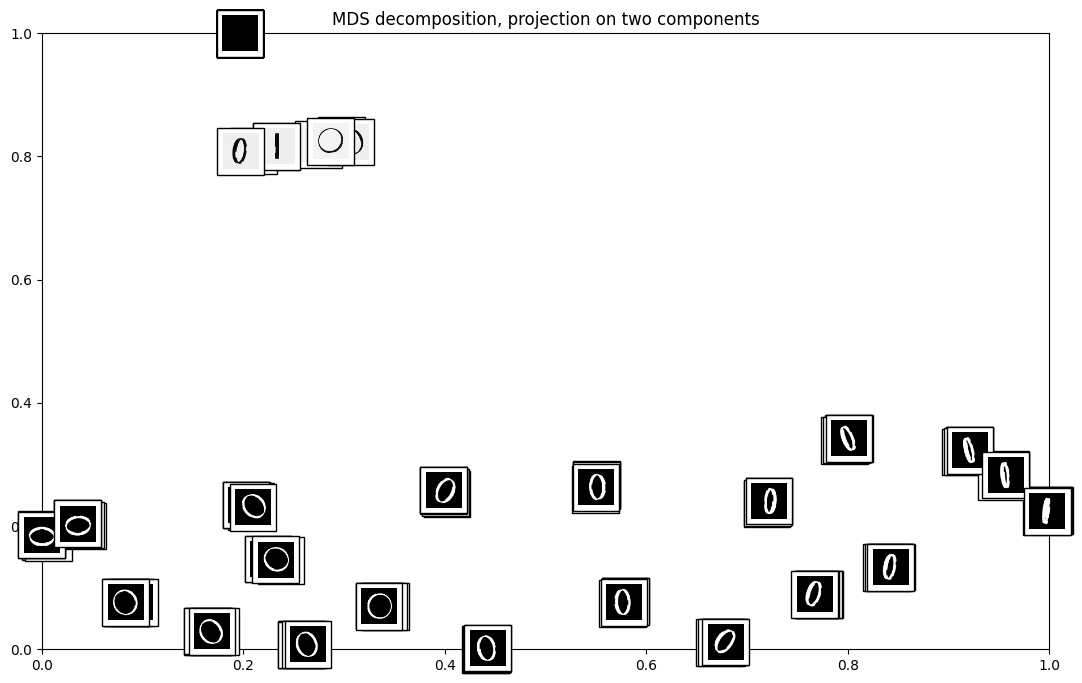

In [ ]:
from sklearn.manifold import MDS

X_projected = MDS(n_components=2).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "MDS decomposition, projection on two components")

In [ ]:
import numpy as np

# Исходный массив
arr = X_projected

# 1. Сортируем массив по X (первый столбец)
sorted_by_x = arr[arr[:, 0].argsort()]

error_rate = 10

# 2. Выбираем левую, центральную и правую точки
left_point = sorted_by_x[0]      # Минимальный X
right_point = sorted_by_x[-1]    # Максимальный X
center_point = sorted_by_x[len(sorted_by_x) // 2]  # Медиана по X

print("Левая точка (min X):", left_point)
print("Центральная точка (медиана X):", center_point)
print("Правая точка (max X):", right_point)

Левая точка (min X): [-6370.95611368   196.25103715]
Центральная точка (медиана X): [-2395.47609079 10790.83966926]
Правая точка (max X): [-493.04524135 4028.30049802]


In [ ]:
diff_images = []
for i in range(len(X_projected)):
  if (X_projected[i][0] == left_point[0] and X_projected[i][1] == left_point[1]) \
  or (X_projected[i][0] == center_point[0] and X_projected[i][1] == center_point[1]) \
  or (X_projected[i][0] == right_point[0] and X_projected[i][1] == right_point[1]):
    diff_images.append(i)
    print(f'{i} - {X_projected[i]}')

73 - [-493.04524135 4028.30049802]
81 - [-2395.47609079 10790.83966926]
84 - [-6370.95611368   196.25103715]


In [ ]:
diff_images

[73, 81, 84]

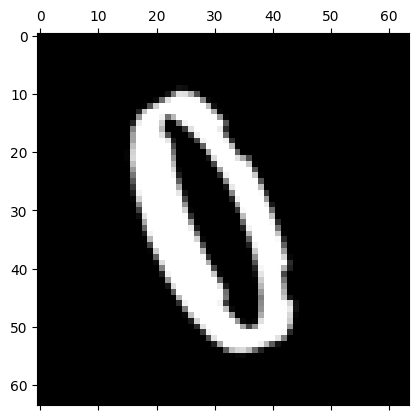

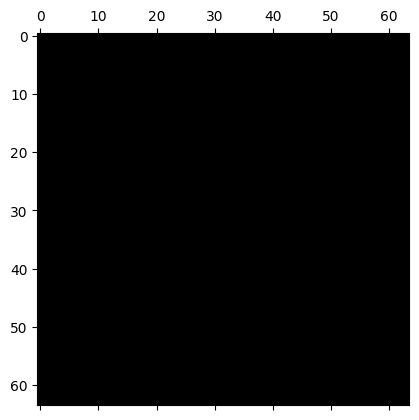

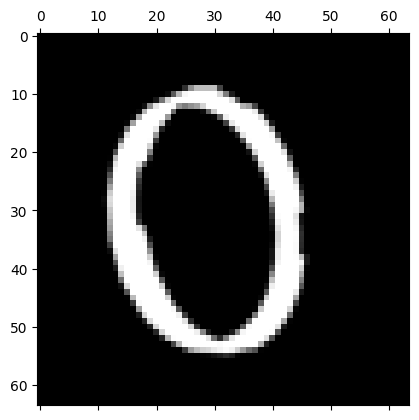

In [ ]:
for image in diff_images:
  plt.matshow(data[image].reshape(64,64), cmap='gray')

In [ ]:
image_names

array(['00006_g.png', '00002_depth.png', '00014_r.png', '00012_g.png',
       '00012_r.png', '00024_depth.png', '00001_g.png', '00019_depth.png',
       '00013.png', '00012_b.png', '00000_depth.png', '00012_depth.png',
       '00000_b.png', '00013_depth.png', '00017_a.png', '00010_b.png',
       '00011_r.png', '00014_b.png', '00000_r.png', '00016_depth.png',
       '00023_depth.png', '00016_a.png', '00007_r.png', '00001_depth.png',
       '00020.png', '00016_b.png', '00021_depth.png', '00001_a.png',
       '00016_r.png', '00015.png', '00010_g.png', '00007_g.png',
       '00002_a.png', '00014_a.png', '00012.png', '00018_r.png',
       '00010_a.png', '00008_depth.png', '00004_b.png', '00013_b.png',
       '00001_b.png', '00009_a.png', '00023.png', '00009_b.png',
       '00018_a.png', '00005.png', '00013_g.png', '00009_g.png',
       '00010.png', '00017_b.png', '00006_a.png', '00002.png',
       '00008_r.png', '00012_a.png', '00014_g.png', '00003_b.png',
       '00006_r.png', '00015_a.png

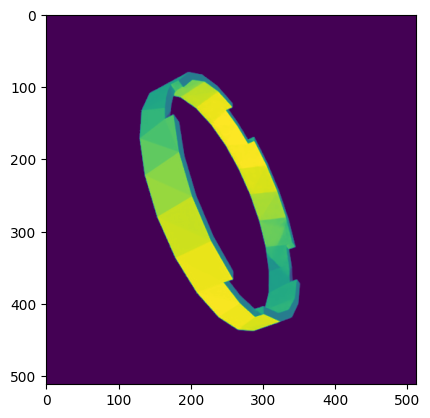

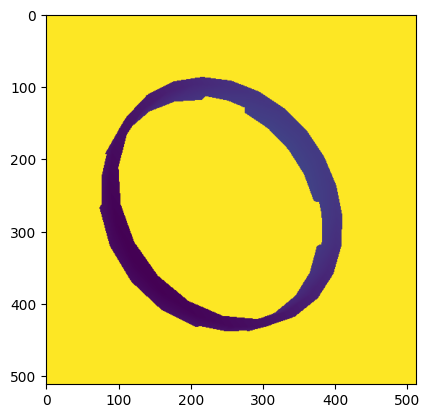

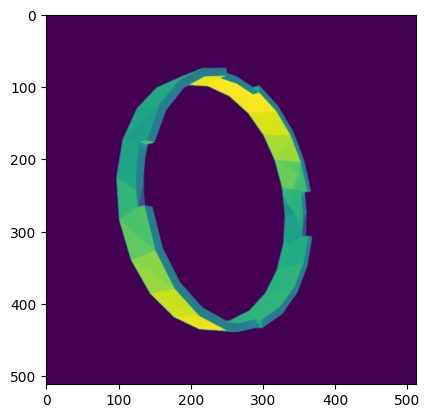

['Model/00019_r.png', 'Model/00009_depth.png', 'Model/00003_g.png']

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

files_for_concat = []

for num in diff_images:
  file_name = os.path.join('Model', image_names[num])
  img = mpimg.imread(file_name)
  files_for_concat.append(file_name)
  plt.imshow(img)
  plt.show()

files_for_concat

In [ ]:
from PIL import Image

# Загружаем изображения
img1 = Image.open(files_for_concat[0])
img2 = Image.open(files_for_concat[1])
img3 = Image.open(files_for_concat[2])

# Проверяем, что все изображения имеют одинаковую высоту
assert img1.height == img2.height == img3.height, "Изображения должны быть одинаковой высоты"

# Создаем новое изображение
total_width = img1.width + img2.width + img3.width
new_img = Image.new('RGB', (total_width, img1.height))

# Вставляем изображения
new_img.paste(img1, (0, 0))
new_img.paste(img2, (img1.width, 0))
new_img.paste(img3, (img1.width + img2.width, 0))

new_img.save("horizontal_combined.jpg")

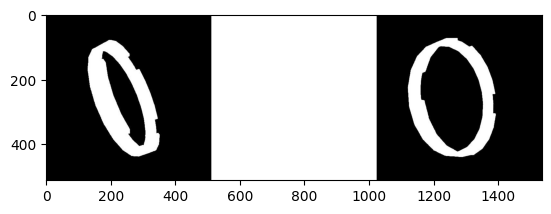

In [ ]:
img = mpimg.imread("horizontal_combined.jpg")
files_for_concat.append(file_name)
plt.imshow(img)
plt.show()